# Predicting Geograph Type Tags via CLIP & Spatial Metadata

A PyTorch implementation designed for efficiency on both CPU and GPU. The pipeline is fully functional within Google Colab environments for immediate experimentation.

Our 'Image Type Tags' are normally allocated by moderator, this dataset is part of process to create a model that can assist a moderator.

The goal of this dataset is to enable the development of multi-modal models that can predict a photograph's archival classification (e.g., Aerial, Inside, Geograph) by combining visual features with spatial distance context.

But note the overall concept of using CLIP Embeddings + Metadata as input a train a model, is clearly inspired by ClipTheLandscape that did the same thing with Geograph Context Tags.
https://github.com/SpaceTimeLab/ClipTheLandscape


In [ ]:
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import base64
import struct
import numpy as np
import math

# --- 1. CONFIGURATION & MAPPINGS ---
# ... note is "Cross Far" is a synthetic tag, created from Cross Grid (only when dist > 256)
CLASSES = ["Aerial", "Close Look", "Cross Far", "Extra", "Geograph", "Inside", "From Drone"]
CLASS_TO_IDX = {cls: i for i, cls in enumerate(CLASSES)}

# Generate power-of-2 map dynamically up to 2^20 (1,048,576)
DIST_MAP = {str(2**i): i + 1 for i in range(21)}
DIST_MAP["0"] = 0
DIST_MAP["Unknown"] = 22
DIST_MAP[""] = 0 # Handle the empty string case in your table

def get_dist_idx(val):
    val_str = str(val).strip()
    return DIST_MAP.get(val_str, DIST_MAP["Unknown"])

# --- 2. DECODER & WEIGHTING RULES ---
CLIP_DIM = 512 # Standard CLIP embedding dimension

# Define a function to decode the Base64-encoded vector
def decode_vector(encoded_str):
    try:
        binary_data = base64.b64decode(encoded_str)
    except Exception as e:
        # Handle potential base64 decoding errors
        print(f"Warning: Error decoding base64 string: {e}. Returning zero vector.")
        return [0.0] * CLIP_DIM

    try:
        decoded_list = np.frombuffer(binary_data, dtype=np.float32)
        # Check for NaN or Inf values within the decoded list
        if any(math.isnan(x) or math.isinf(x) for x in decoded_list):
            print(f"Warning: NaN or Inf values detected in decoded embedding. Returning zero vector.")
            return [0.0] * CLIP_DIM
        return decoded_list
    except Exception as e:
        # Catch any other unpacking errors
        print(f"Warning: Error unpacking binary data: {e}. Returning zero vector.")
        return [0.0] * CLIP_DIM

def calculate_sample_weight(types_str, distance):
    """Implementing the rules we discussed for noisy labels."""
    types = types_str.split(',')
    dist_val = str(distance)

    # Rule 1: Geograph with far or unknown distance = Low weight (Noisy)
    if "Geograph" in types and (dist_val == "Unknown" or (dist_val.isdigit() and int(dist_val) > 256)):
        return 0.2

    # Rule 2: Cross Grid with close distance = Re-label conceptually as Geograph proxy
    # We give it a medium weight because visually it's a Geograph, not Cross-Far
    if "Cross Grid" in types and dist_val.isdigit() and int(dist_val) <= 256:
        return 0.5

    return 1.0 # Standard weight for clear examples

# --- 3. DATASET CLASS ---
class MultimodalGeographDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Process Embeddings
        vec = torch.tensor(decode_vector(item['embeddings']), dtype=torch.float32)

        # Process Distance
        dist_idx = torch.tensor(get_dist_idx(item['distance']), dtype=torch.long)

        # Process Multi-labels (One-Hot Encoding)
        label_tensor = torch.zeros(len(CLASSES))
        raw_types = item['types'].split(',')
        for t in raw_types:
            # Note: We treat "Cross Grid" as "Cross Far" for the target label if dist > 256
            clean_t = t.strip()
            if clean_t == "Cross Grid":
                if str(item['distance']).isdigit() and int(item['distance']) > 256:
                    clean_t = "Cross Far"
                elif len(raw_types) == 1: ##if was ONLY gross grid, then change it
                    clean_t = "Geograph" # Visual proxy
                else: #else just ignore the CR (can still be inside etc)
                    continue

            # NEW: Funnel 'From Above' into the Drone class
            # its a fake tag for images that look like drone, but probably
            # arent. but included so the model can learn from them.
            if clean_t == "From Above":
                clean_t = "From Drone"

            if clean_t in CLASS_TO_IDX:
                label_tensor[CLASS_TO_IDX[clean_t]] = 1.0

        # Calculate Weight
        ##weight = torch.tensor(calculate_sample_weight(item['types'], item['distance']), dtype=torch.float32)
        weight = torch.tensor(item.get('weight', 1.0), dtype=torch.float32)

        return vec, dist_idx, label_tensor, weight

In [ ]:
!wget 'https://development.geograph.org.uk/ai/types_dataset_1.jsonl.gz' -O stratified_geograph_v1.jsonl.gz
!gunzip stratified_geograph_v1.jsonl.gz
!wc -l stratified_geograph_v1.jsonl

--2026-01-15 14:09:34--  https://development.geograph.org.uk/ai/types_dataset_1.jsonl.gz
Resolving development.geograph.org.uk (development.geograph.org.uk)... 104.26.7.236, 104.26.6.236, 172.67.71.30, ...
Connecting to development.geograph.org.uk (development.geograph.org.uk)|104.26.7.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254250627 (242M) [application/octet-stream]
Saving to: ‘stratified_geograph_v1.jsonl.gz’

stratified_geograph 100%[===================>] 242.47M   252MB/s    in 1.0s    

2026-01-15 14:09:35 (252 MB/s) - ‘stratified_geograph_v1.jsonl.gz’ saved [254250627/254250627]

121930 stratified_geograph_v1.jsonl


In [ ]:
#@title main loader
import json
import base64
import struct

def load_jsonl_data(filepath):
    raw_data = []
    print(f"Opening {filepath}...")

    with open(filepath, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f):
            try:
                # Load the JSON line
                item = json.loads(line)

                # Check for required keys - changed 'embedding' to 'embeddings'
                if all(k in item for k in ('types', 'distance', 'embeddings')):
                    raw_data.append(item)
                else:
                    print(f"Warning: Missing keys at line {line_num}. Item: {item}")

            except json.JSONDecodeError as e:
                print(f"Error decoding JSON at line {line_num}: {e}")
                continue

    print(f"Successfully loaded {len(raw_data)} records.")
    return raw_data

# --- EXECUTION ---
# Path to your file in Colab (e.g., from Google Drive or local upload)
FILE_PATH = 'stratified_geograph_v1.jsonl'

# Load the data
raw_data = load_jsonl_data(FILE_PATH)

# Quick verification of the first record
if raw_data:
    print("\nSample Record 23:")
    print(f"ID: {raw_data[23].get('gridimage_id', 'N/A')}")
    print(f"Types: {raw_data[23]['types']}")
    print(f"Distance: {raw_data[23]['distance']}")
    # Only show the first few bytes of embedding to keep the console clean
    print(f"Embedding snippet: {raw_data[23]['embeddings'][:30]}...")

Opening stratified_geograph_v1.jsonl...
Successfully loaded 121930 records.

Sample Record 23:
ID: 15345
Types: Cross Grid
Distance: 512
Embedding snippet: 3shDvtDbeD7MZA29rEWNPV1doT7Hsu...


In [ ]:
# @title Updated GeographModel with Save/Load
import torch
import torch.nn as nn
import os

class GeographModel(nn.Module):
    def __init__(self, clip_dim=512, dist_embed_dim=16, classes=None, dist_map=None):
        super().__init__()
        # Store metadata within the class for easy access
        self.classes = classes if classes else ["Aerial", "Close Look", "Cross Far", "Extra", "Geograph", "Inside", "From Drone"]
        self.dist_map = dist_map if dist_map else {}

        self.dist_emb = nn.Embedding(len(self.dist_map) if self.dist_map else 15, dist_embed_dim)

        self.fc = nn.Sequential(
            nn.Linear(clip_dim + dist_embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, len(self.classes))
        )

    def forward(self, clip_vec, dist_idx):
        d_feat = self.dist_emb(dist_idx)
        combined = torch.cat([clip_vec, d_feat], dim=1)
        return self.fc(combined)

    def save_checkpoint(self, filepath, optimizer=None, epoch=None, loss=None):
        """Saves the model weights and all necessary metadata to disk."""
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'classes': self.classes,
            'dist_map': self.dist_map,
            'clip_dim': 512, # Assuming standard CLIP
            'dist_embed_dim': 16,
            'epoch': epoch,
            'optimizer_state_dict': optimizer.state_dict() if optimizer else None,
            'loss': loss
        }
        torch.save(checkpoint, filepath)
        print(f"Model saved to {filepath}")

    @classmethod
    def load_checkpoint(cls, filepath, device='cpu'):
        """
        Loads the model and metadata.
        Returns an initialized model ready for inference.
        """
        checkpoint = torch.load(filepath, map_location=device)

        # Reconstruct the class with the saved metadata
        model = cls(
            clip_dim=checkpoint['clip_dim'],
            dist_embed_dim=checkpoint['dist_embed_dim'],
            classes=checkpoint['classes'],
            dist_map=checkpoint['dist_map']
        )

        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval() # Set to evaluation mode by default
        print(f"Model loaded from {filepath} (Epoch: {checkpoint.get('epoch')})")
        return model, checkpoint

In [ ]:
#@title load splits from dataset
# 1. Load all records into a single list
raw_data = load_jsonl_data("stratified_geograph_v1.jsonl")

# 2. Identify indices for each split
# This is much faster and more memory-efficient than duplicating the data
train_indices = [i for i, item in enumerate(raw_data) if item.get('split') == 'tra']
val_indices   = [i for i, item in enumerate(raw_data) if item.get('split') == 'val']
test_indices  = [i for i, item in enumerate(raw_data) if item.get('split') == 'tes']

# 3. Create the Master Dataset
full_dataset = MultimodalGeographDataset(raw_data)

# 4. Use Torch Subset to create the split datasets
from torch.utils.data import Subset

train_set = Subset(full_dataset, train_indices)
val_set   = Subset(full_dataset, val_indices)
test_set  = Subset(full_dataset, test_indices)

print(f"Dataset Split: Train={len(train_indices)}, Val={len(val_indices)}, Test={len(test_indices)}")


Opening stratified_geograph_v1.jsonl...
Successfully loaded 121930 records.
Dataset Split: Train=97528, Val=12159, Test=12243


In [ ]:
#@title Create DataLoaders
# shuffle=True is crucial for training to prevent the model from learning patterns in the order of the file
train_loader = DataLoader(train_set, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Train batches: 96
Validation batches: 12


In [ ]:
#@title verify splits
import pandas as pd
from collections import Counter

def verify_splits(raw_data):
    stats = []

    ##need local cop as need to revert to Cross Grid, not our puysud Cross Far
    CLASSES = ["Aerial", "Close Look", "Cross Grid", "Extra", "Geograph", "Inside", "From Drone"]

    for split_name in ['tra', 'val', 'tes']:
        # Filter data for this split
        split_items = [item for item in raw_data if item.get('split') == split_name]
        total = len(split_items)

        if total == 0:
            print(f"Warning: Split '{split_name}' is empty!")
            continue

        # Count classes (handling multi-label)
        class_counts = Counter()
        distances = []

        for item in split_items:
            # Distance stats (convert to float, treat Unknown/Empty as 0 for stats)
            d = str(item.get('distance', '0')).strip()
            distances.append(float(d) if d.isdigit() else 0.0)

            # Label stats
            for t in item.get('types', '').split(','):
                class_counts[t.strip()] += 1

        # Format stats for this split
        row = {
            "Split": split_name,
            "Total": total,
            "Avg Dist": f"{sum(distances)/total:.1f}m"
        }

        # Add percentages for each class to see if they are balanced
        for cls in CLASSES:
            count = class_counts.get(cls, 0)
            row[cls] = f"{(count/total)*100:.3f}%"

        stats.append(row)

    # Display as a nice table
    df = pd.DataFrame(stats)
    return df

# Run the check
df_stats = verify_splits(raw_data)
print(df_stats.to_string(index=False))

Split  Total Avg Dist  Aerial Close Look Cross Grid  Extra Geograph  Inside From Drone
  tra  97528   211.7m 13.299%    21.586%    23.540% 7.893%  32.818% 16.472%     0.044%
  val  12159   206.6m 13.537%    21.795%    23.579% 7.846%  32.897% 16.449%     0.041%
  tes  12243   202.3m 13.240%    22.192%    23.417% 7.490%  33.260% 16.344%     0.049%


In [ ]:
# @title The complete training loop

import torch.optim as optim
from tqdm.auto import tqdm # Progress bars for Colab

# --- 1. INITIALIZE COMPONENTS ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GeographModel(classes=CLASSES, dist_map=DIST_MAP).to(device)

# We use Adam for its robust adaptive learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Reduction='none' is essential to apply our per-sample weights manually
criterion = nn.BCEWithLogitsLoss(reduction='none')

# --- 2. THE TRAINING & VALIDATION LOOPS ---
def run_training(num_epochs=50, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train()
        train_loss = 0.0

        for vecs, dists, labels, weights in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            vecs, dists, labels, weights = vecs.to(device), dists.to(device), labels.to(device), weights.to(device)

            optimizer.zero_grad()
            outputs = model(vecs, dists)

            # Calculate BCE loss per class, per sample
            raw_loss = criterion(outputs, labels) # Shape: [batch_size, num_classes]

            # Average across classes, then multiply by our custom sample weights
            sample_loss = raw_loss.mean(dim=1) * weights
            loss = sample_loss.mean()

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # --- VALIDATION PHASE ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for vecs, dists, labels, weights in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                vecs, dists, labels, weights = vecs.to(device), dists.to(device), labels.to(device), weights.to(device)

                outputs = model(vecs, dists)
                raw_loss = criterion(outputs, labels)
                # Note: We still use weights in validation to get a "fair" comparison
                sample_loss = raw_loss.mean(dim=1) * weights
                val_loss += sample_loss.mean().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # --- EARLY STOPPING & SAVING ---
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the best version found so far
            model.save_checkpoint("best_geograph_model.pth", optimizer, epoch, avg_val_loss)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered! No improvement for {patience} epochs.")
                break

# Run it!
run_training(num_epochs=50, patience=7)

Epoch 1 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1: Train Loss: 0.1912 | Val Loss: 0.0937
Model saved to best_geograph_model.pth


Epoch 2 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.0877 | Val Loss: 0.0792
Model saved to best_geograph_model.pth


Epoch 3 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.0786 | Val Loss: 0.0750
Model saved to best_geograph_model.pth


Epoch 4 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.0750 | Val Loss: 0.0734
Model saved to best_geograph_model.pth


Epoch 5 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0730 | Val Loss: 0.0720
Model saved to best_geograph_model.pth


Epoch 6 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0713 | Val Loss: 0.0711
Model saved to best_geograph_model.pth


Epoch 7 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0704 | Val Loss: 0.0707
Model saved to best_geograph_model.pth


Epoch 8 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0694 | Val Loss: 0.0703
Model saved to best_geograph_model.pth


Epoch 9 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0685 | Val Loss: 0.0695
Model saved to best_geograph_model.pth


Epoch 10 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0676 | Val Loss: 0.0692
Model saved to best_geograph_model.pth


Epoch 11 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.0667 | Val Loss: 0.0690
Model saved to best_geograph_model.pth


Epoch 12 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12: Train Loss: 0.0659 | Val Loss: 0.0687
Model saved to best_geograph_model.pth


Epoch 13 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13: Train Loss: 0.0653 | Val Loss: 0.0686
Model saved to best_geograph_model.pth


Epoch 14 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14: Train Loss: 0.0646 | Val Loss: 0.0686


Epoch 15 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15: Train Loss: 0.0639 | Val Loss: 0.0687


Epoch 16 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 16: Train Loss: 0.0630 | Val Loss: 0.0687


Epoch 17 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 17: Train Loss: 0.0624 | Val Loss: 0.0689


Epoch 18 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 18: Train Loss: 0.0614 | Val Loss: 0.0685
Model saved to best_geograph_model.pth


Epoch 19 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 19: Train Loss: 0.0608 | Val Loss: 0.0685
Model saved to best_geograph_model.pth


Epoch 20 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 20: Train Loss: 0.0601 | Val Loss: 0.0685


Epoch 21 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 21: Train Loss: 0.0595 | Val Loss: 0.0689


Epoch 22 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 22: Train Loss: 0.0587 | Val Loss: 0.0692


Epoch 23 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 23: Train Loss: 0.0580 | Val Loss: 0.0693


Epoch 24 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 24: Train Loss: 0.0574 | Val Loss: 0.0692


Epoch 25 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 25: Train Loss: 0.0564 | Val Loss: 0.0695


Epoch 26 [Train]:   0%|          | 0/96 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 26: Train Loss: 0.0560 | Val Loss: 0.0701
Early stopping triggered! No improvement for 7 epochs.


In [ ]:
#@title (re)Load the peak performer
model, checkpoint = GeographModel.load_checkpoint("best_geograph_model.pth", device)

Model loaded from best_geograph_model.pth (Epoch: 12)


In [ ]:
#@title Classification Report
from sklearn.metrics import classification_report
import numpy as np
import torch

def evaluate_model_performance(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    print("Generating Classification Report...")

    with torch.no_grad():
        for vecs, dists, labels, weights in test_loader:
            vecs, dists, labels = vecs.to(device), dists.to(device), labels.to(device)

            # 1. Get raw model outputs (logits)
            outputs = model(vecs, dists)

            # 2. Convert logits to binary predictions (0 or 1)
            # Since we use BCEWithLogitsLoss, we apply a sigmoid and then threshold at 0.5
            preds = torch.sigmoid(outputs) > 0.5

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Combine all batches
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # 3. Generate the report
    # target_names ensures the report uses 'Inside', 'Aerial', etc. instead of 0, 1, 2...
    report = classification_report(
        all_labels,
        all_preds,
        target_names=CLASSES,
        zero_division=0
    )

    print("\n" + report)

# --- EXECUTION ---
# Ensure your test_loader is ready (shuffle=False for evaluation)
evaluate_model_performance(model, test_loader, device)

Generating Classification Report...

              precision    recall  f1-score   support

      Aerial       0.99      0.97      0.98      1621
  Close Look       0.80      0.85      0.83      2717
   Cross Far       0.91      0.99      0.95      1444
       Extra       0.84      0.75      0.79       917
    Geograph       0.95      0.95      0.95      5325
      Inside       0.96      0.96      0.96      2001
  From Drone       0.00      0.00      0.00         6

   micro avg       0.91      0.93      0.92     14031
   macro avg       0.78      0.78      0.78     14031
weighted avg       0.92      0.93      0.92     14031
 samples avg       0.91      0.92      0.91     14031



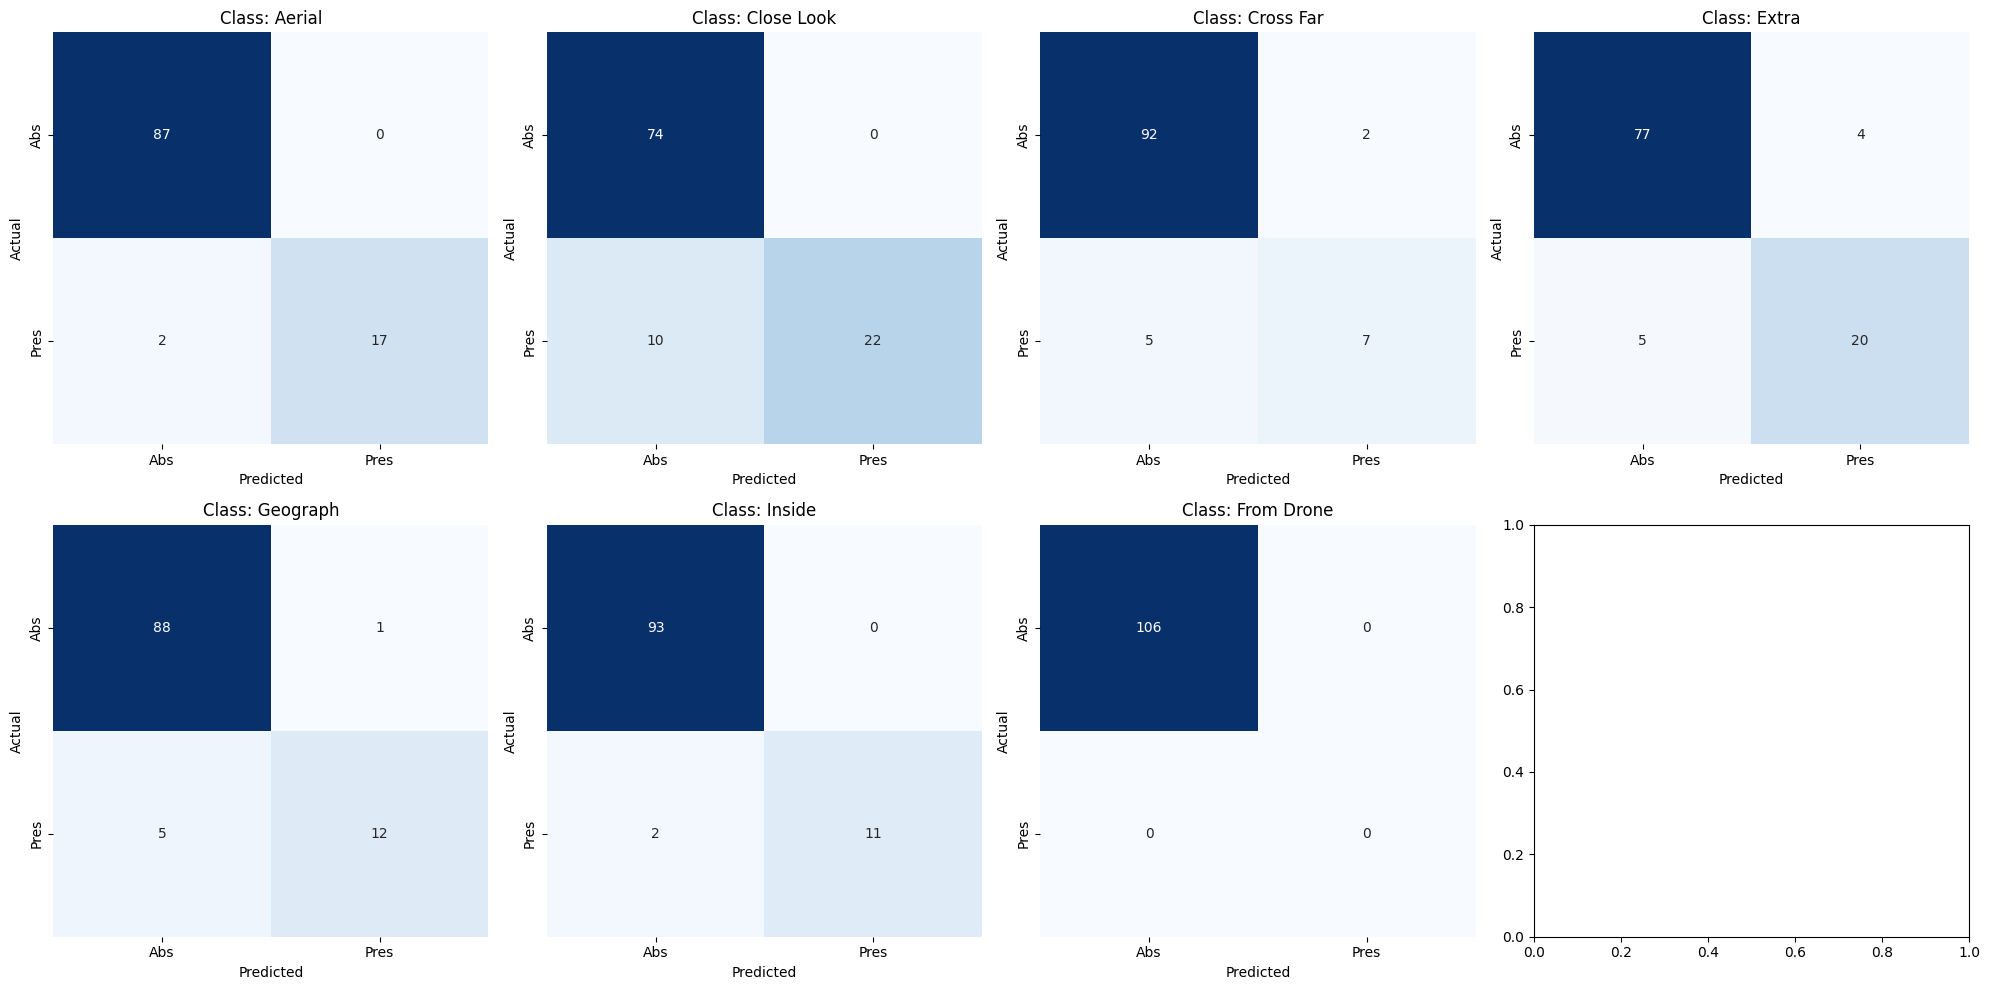

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

def plot_visual_confusion_matrix(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for vecs, dists, labels, _ in loader:
            outputs = model(vecs.to(device), dists.to(device))
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()
            y_true.append(labels.numpy())
            y_pred.append(preds)

    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # Plotting
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    for i, (matrix, name) in enumerate(zip(mcm, CLASSES)):
        sns.heatmap(matrix, annot=True, fmt='d', ax=axes[i], cmap='Blues', cbar=False)
        axes[i].set_title(f"Class: {name}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
        # Labels: 0 = Absent, 1 = Present
        axes[i].set_xticklabels(['Abs', 'Pres'])
        axes[i].set_yticklabels(['Abs', 'Pres'])

    plt.tight_layout()
    plt.show()

# Run after training
plot_visual_confusion_matrix(model, val_loader, device)

In [ ]:
# @title After your training loop
model.save_checkpoint(
    "geograph_classifier_v1.pth",
    optimizer=optimizer,
    epoch=10,
    loss=0.045
)

In [ ]:
# @title load model

# You can do this in a completely fresh notebook!
# Just make sure the GeographModel class is defined.
loaded_model, metadata = GeographModel.load_checkpoint("geograph_classifier_v1.pth")

# Now you can use the metadata to interpret results
print(f"This model predicts these classes: {loaded_model.classes}")

In [ ]:
!wget 'https://development.geograph.org.uk/ai/types_dataset_unknown.jsonl' -O types_dataset_unknown.jsonl

--2026-01-15 14:08:26--  https://development.geograph.org.uk/ai/types_dataset_unknown.jsonl
Resolving development.geograph.org.uk (development.geograph.org.uk)... 104.26.6.236, 104.26.7.236, 172.67.71.30, ...
Connecting to development.geograph.org.uk (development.geograph.org.uk)|104.26.6.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29255 (29K) [application/octet-stream]
Saving to: ‘types_dataset_unknown.jsonl’

types_dataset_unkno 100%[===================>]  28.57K  --.-KB/s    in 0.1s    

2026-01-15 14:08:27 (286 KB/s) - ‘types_dataset_unknown.jsonl’ saved [29255/29255]



In [ ]:
#@title The Inference Loop & Display Script
import torch
from IPython.display import display, HTML

def run_inference_on_unknowns(model, raw_unknown_data, device, threshold=0.5):
    model.eval()
    results_html = '<div style="display: flex; flex-wrap: wrap;">'

    print(f"Running inference on {len(raw_unknown_data)} images...")

    with torch.no_grad():
        for item in raw_unknown_data:
            # 1. Prepare Inputs
            vec = torch.from_numpy(decode_vector(item['embeddings'])).unsqueeze(0).to(device)
            dist_idx = torch.tensor([get_dist_idx(item.get('distance', 'Unknown'))], dtype=torch.long).to(device)

            # 2. Predict
            outputs = model(vec, dist_idx)
            probs = torch.sigmoid(outputs).cpu().numpy()[0]

            # 3. Filter classes above threshold
            predicted_tags = [CLASSES[i] for i, prob in enumerate(probs) if prob > threshold]

            # If nothing hits the threshold, take the top 1 as a "guess"
            if not predicted_tags:
                top_idx = probs.argmax()
                predicted_tags = [f"{CLASSES[top_idx]} (Low Confidence)"]

            # 4. Build a nice UI card for Colab
            thumb = item.get('path', 'about:blank')
            title = item.get('title', f"ID: {item.get('gridimage_id')}")
            tags_html = "".join([f'<span style="background:#eee; padding:2px 5px; margin:2px; border-radius:3px; font-size:12px;">{t}</span>' for t in predicted_tags])

            results_html += f'''
                <div style="border: 1px solid #ddd; margin: 10px; padding: 10px; width: 180px; text-align: center;">
                    <img src="https://s0.geograph.org.uk{thumb}" style="width: 150px; height: 150px; object-fit: cover;"><br>
                    <b style="font-size: 13px;">{title}</b><br>
                    <div style="margin-top:8px;">{tags_html}</div>
                </div>
            '''

    results_html += '</div>'
    display(HTML(results_html))

# --- EXECUTION ---
# Assuming 'unknown_samples' is your list of 10-100 dicts

unknown_samples = load_jsonl_data('types_dataset_unknown.jsonl')

run_inference_on_unknowns(model, unknown_samples, device)